In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#!pip install scikit-learn --upgrade
from keras import Model
from sklearn.decomposition import PCA
from scipy import signal
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import joblib

In [ ]:
#import data
df1 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_andrea.csv')
df2 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_christian.csv')
df3 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giovanni.csv')
df4 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_beste.csv')
df5 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_valerio.csv')
df6 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_test.csv')


#removing all the data before the start of the protocol - run only one time!!
df1 = df1[df1.iloc[:, 9] != 'Null']
df2 = df2[df2.iloc[:, 9] != 'Null']
df3 = df3[df3.iloc[:, 9] != 'Null']
df4 = df4[df4.iloc[:, 9] != 'Null']
df5 = df5[df5.iloc[:, 9] != 'Null']
df6 = df6[df6.iloc[:, 9] != 'Null']

#------removing first value for capturing variation of the data respect to the starting moment
def subtract_first_row(df):
    first_row_numeric = df.iloc[0, :-1]
    df_subtracted = df.copy()
    df_subtracted.iloc[:, :-1] = df_subtracted.iloc[:, :-1].subtract(first_row_numeric, axis='columns')
    return df_subtracted

df1 = subtract_first_row(df1)
df2 = subtract_first_row(df2)
df3 = subtract_first_row(df3)
df4 = subtract_first_row(df4)
df5 = subtract_first_row(df5)
df6 = subtract_first_row(df6)

df_test = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
df_test.dropna(inplace=True)
df_test = df_test[['Eulerx','Gyroy','Gyroz','Label']]


In [ ]:
#UPDATE - NUOVA FUNZIONE CREATE_WINDOWS FUNZIONANTE!

n_features = len(df_test.columns) -1
n_classes = df_test['Label'].nunique()
window_size = 16 #circa mezzo secondo, 16 perchè era necessario avere potenza di 2 per fft su arduino!!!!!

def create_windows(data, window_size):
    num_rows = len(data)
    if num_rows <= window_size:
        raise ValueError("La dimensione della finestra è maggiore o uguale al numero di righe nel dataset.")

    # Pre-alloca X e y
    n_windows = num_rows - window_size
    n_features = data.shape[1] - 1  # Numero di caratteristiche (escludendo la colonna di etichette)

    X = np.empty((n_windows, window_size, n_features), dtype=data.iloc[:, :-1].values.dtype)
    y = np.empty(n_windows, dtype=data.iloc[:, -1].values.dtype)

    for i in range(n_windows):
        X[i] = data.iloc[i:i + window_size, :-1].values
        y[i] = data.iloc[i + window_size - 1, -1]

    return X, y

def calculate_fft(X):
    X_fft = []
    for timeseries in X:
        fft_features = []
        for i in range(timeseries.shape[1]):  # Itera su ogni feature
            fft_result = np.fft.fft(timeseries[:, i])  # FFT per la i-esima feature
            fft_magnitude = np.abs(fft_result[:len(fft_result)//2])  # Prendi la magnitudine dei valori complessi e usa solo metà dello spettro
            fft_features.append(fft_magnitude.astype(float))
        X_fft.append(np.hstack(fft_features))  # Concatenazione delle fft di tutte le feature
    return np.array(X_fft)

In [ ]:
#time series
#pattern-time series
"""
window_size = 16 #circa mezzo secondo, 16 perchè era necessario avere potenza di 2 per fft su arduino!!!!!
n_features = len(df_test.columns) -1
n_classes = df_test['Label'].nunique()
def create_windows(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size, :-1].values)
        y.append(data.iloc[i+window_size-1, -1])
    return np.array(X), np.array(y)


def calculate_psd(X):
    X_psd = []
    for timeseries in X:
        psd_features = []
        for i in range(timeseries.shape[1]):
            f, psd = signal.welch(timeseries[:, i], fs=30, nperseg=min(256, len(timeseries)))
            psd_features.append(np.abs(psd).astype(float))  # Use np.abs to get magnitude of complex numbers
        X_psd.append(np.hstack(psd_features))
    return np.array(X_psd)
def calculate_fft(X):
    X_fft = []
    for timeseries in X:
        fft_features = []
        for i in range(timeseries.shape[1]):  # Itera su ogni feature
            fft_result = np.fft.fft(timeseries[:, i])  # FFT per la i-esima feature
            fft_magnitude = np.abs(fft_result[:len(fft_result)//2])  # Prendi la magnitudine dei valori complessi e usa solo metà dello spettro
            fft_features.append(fft_magnitude.astype(float))
        X_fft.append(np.hstack(fft_features))  # Concatenazione delle fft di tutte le feature
    return np.array(X_fft)

"""

In [ ]:
#prediction on test set
X_test, y_test = create_windows(df_test, window_size)
y_test = to_categorical(y_test, num_classes=n_classes)
y_test = np.argmax(y_test, axis=1)

#X_test_psd = calculate_psd(X_test)
X_test_fft = calculate_fft(X_test)
#scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/MPUTOYCODE/spectrumclassification/scaler_fft_16tw.pkl')  non usiamo scaler!!!!!
#X_test_psd = scaler.transform(X_test_psd)
#X_test_fft = scaler.transform(X_test_fft)


#clf_dt = joblib.load('/content/drive/MyDrive/Colab Notebooks/MPUTOYCODE/spectrumclassification/decision_tree_model.pkl')
clf_dt = joblib.load('/content/drive/MyDrive/Colab Notebooks/MPUTOYCODE/spectrumclassification/best_model_16tw_noscaler(1).pkl') #best_model_16tw_noscaler(1).pkl best model trained with fft data - 16 sample time windows - NO SCALER - ft x gy gz
# file con (1) è a profondità 10, per runnare qui, quello senza (1) è a profondità 8 per runnare su esp (qui da errore)
#file con (2) sostituisce gy a gz (tentativo fatto per vedere se migliorava, ma meglio avere x, gy,gz come ft piuttosto che x,gx,gy) quindi non usare
#y_test_pred_dt = clf_dt.predict(X_test_psd)
y_test_pred_dt = clf_dt.predict(X_test_fft)

test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f'Test Accuracy decision tree: {test_accuracy_dt}')
print(classification_report(y_test, y_test_pred_dt))
conf_matrix = confusion_matrix(y_test, y_test_pred_dt)
print('Confusion Matrix:')
print(conf_matrix)


Test Accuracy decision tree: 0.8080438515387663
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     18619
           1       0.89      0.85      0.87     20065
           2       0.69      0.60      0.64     19424
           3       0.96      0.99      0.97     17602

    accuracy                           0.81     75710
   macro avg       0.81      0.81      0.81     75710
weighted avg       0.81      0.81      0.81     75710

Confusion Matrix:
[[14992   739  2870    18]
 [  151 17152  2213   549]
 [ 6359  1304 11565   196]
 [   13    80    41 17468]]


Accuracy: 0.8342822419783094
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     18619
           1       0.94      0.90      0.92     20065
           2       0.75      0.63      0.68     19424
           3       0.96      0.99      0.98     17593

    accuracy                           0.83     75701
   macro avg       0.84      0.84      0.83     75701
weighted avg       0.84      0.83      0.83     75701

Confusion Matrix:
[[15505   474  2640     0]
 [  135 18014  1441   475]
 [ 6488   589 12177   170]
 [   15    82    36 17460]]


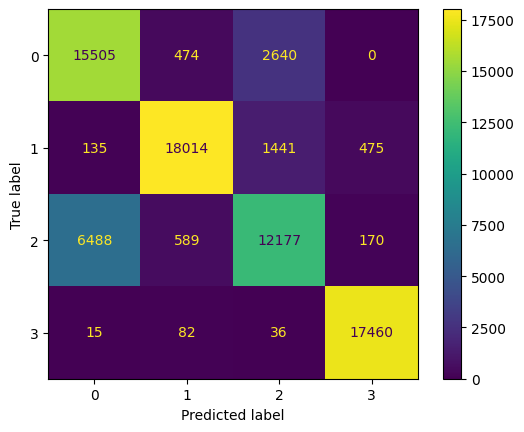

In [ ]:
def majority_voting(predictions, window_size=5): #dimesione finestrra usata su esp32
    """
    Applica il majority voting su una sequenza di predizioni.

    Args:
        predictions: Un array NumPy di predizioni.
        window_size: La dimensione della finestra per il voting.

    Returns:
        Un array NumPy di predizioni dopo il majority voting.
    """

    voted_predictions = []
    for i in range(len(predictions) - window_size + 1):
        window = predictions[i : i + window_size]
        # Trova l'etichetta più frequente nella finestra
        most_frequent_label = np.bincount(window).argmax()
        voted_predictions.append(most_frequent_label)

    return np.array(voted_predictions)

# Applica il majority voting alle classi vere
voted_true_classes = majority_voting(y_test)
voted_predictions = majority_voting(y_test_pred_dt)
# Assicurati che le predizioni votate e le classi vere votate abbiano la stessa lunghezza
min_length = min(len(voted_predictions), len(voted_true_classes))
voted_predictions = voted_predictions[:min_length]
voted_true_classes = voted_true_classes[:min_length]

# Calcola l'accuracy
accuracy = accuracy_score(voted_true_classes, voted_predictions)
print(f'Accuracy: {accuracy}')

# Calcola il classification report
classification_rep = classification_report(voted_true_classes, voted_predictions)
print(f'Classification Report:\n{classification_rep}')

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(voted_true_classes, voted_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# Puoi anche visualizzare la matrice di confusione con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()